# EWMA and Holt-Winters Code

In [1]:
import numpy as np
import pandas as pd 

In [2]:
df = pd.read_csv("../Data/airline_passengers.csv", index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.isna().sum()

Passengers    0
dtype: int64

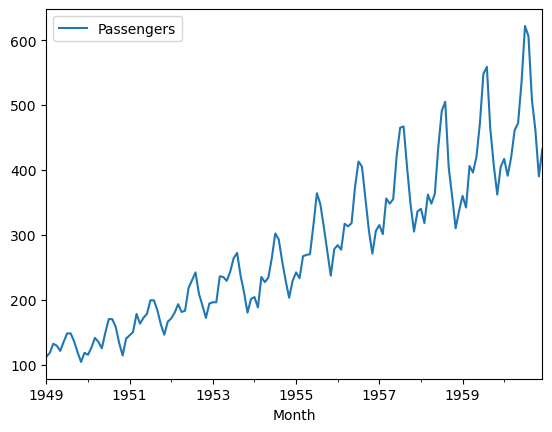

In [4]:
df.plot();

In [5]:
alpha = 0.2

In [6]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [7]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [8]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

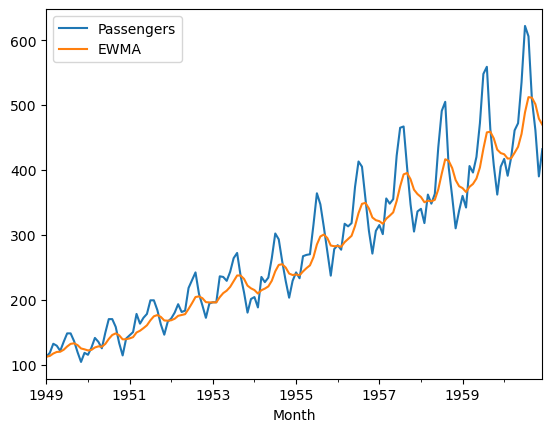

In [9]:
df.plot();

## Simple Exponential Smoothing

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [11]:
ses = SimpleExpSmoothing(df['Passengers'])

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [13]:
df.index.freq = 'MS'

In [14]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [15]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [16]:
res

In [17]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [18]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [19]:
np.allclose(df['SES'], res.fittedvalues)

True

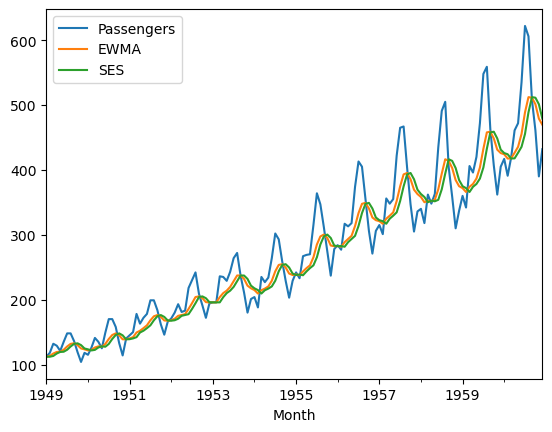

In [20]:
df.plot();

In [21]:
df.head(10)

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,113.200000,112.000000
1949-03-01,132,116.960000,113.200000
1949-04-01,129,119.368000,116.960000
1949-05-01,121,119.694400,119.368000
1949-06-01,135,122.755520,119.694400
1949-07-01,148,127.804416,122.755520
1949-08-01,148,131.843533,127.804416
1949-09-01,136,132.674826,131.843533


In [22]:
# No - Don't do this
df['SES-1'] = df['SES'].shift(-1)

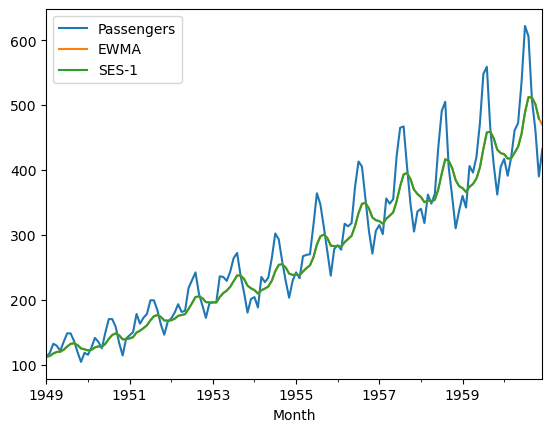

In [23]:
# No - Don't do this
df[['Passengers', 'EWMA', 'SES-1']].plot();

### Start of Forecast

In [24]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [25]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [26]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

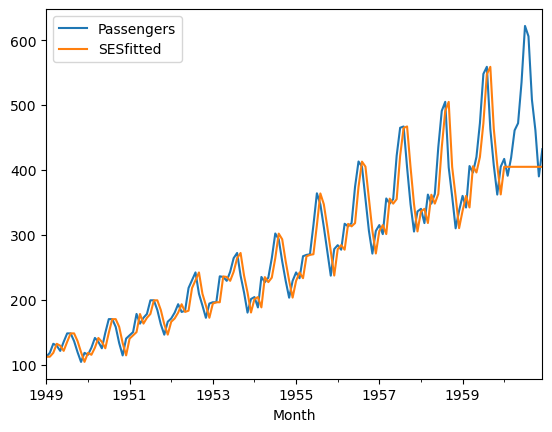

In [27]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [28]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [29]:
df.head()

,Passengers,EWMA,SES,SES-1,SESfitted
Month,,,,,
1949-01-01,112,112.0000,112.000,112.0000,112.000000
1949-02-01,118,113.2000,112.000,113.2000,112.000000
1949-03-01,132,116.9600,113.200,116.9600,117.970000
1949-04-01,129,119.3680,116.960,119.3680,131.929850
1949-05-01,121,119.6944,119.368,119.6944,129.014649


In [30]:
df.tail()

,Passengers,EWMA,SES,SES-1,SESfitted
Month,,,,,
1960-08-01,606,512.214093,488.767616,512.214093,404.786132
1960-09-01,508,511.371274,512.214093,511.371274,404.786132
1960-10-01,461,501.297019,511.371274,501.297019,404.786132
1960-11-01,390,479.037615,501.297019,479.037615,404.786132
1960-12-01,432,469.630092,479.037615,NaN,404.786132


## Start Holt Method

In [31]:
from statsmodels.tsa.holtwinters import Holt

In [32]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [33]:
res_h = holt.fit()

In [34]:
df['Holt'] = res_h.fittedvalues

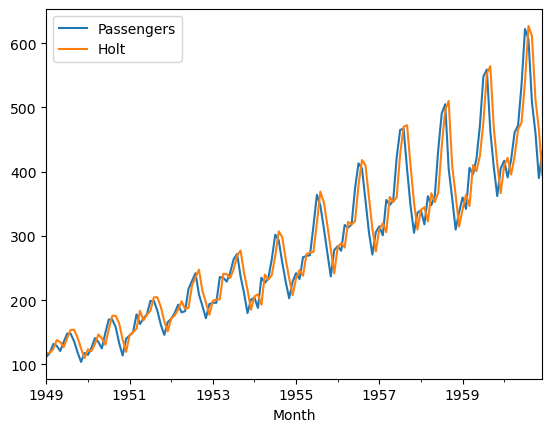

In [35]:
df[['Passengers', 'Holt']].plot();

In [36]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [37]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

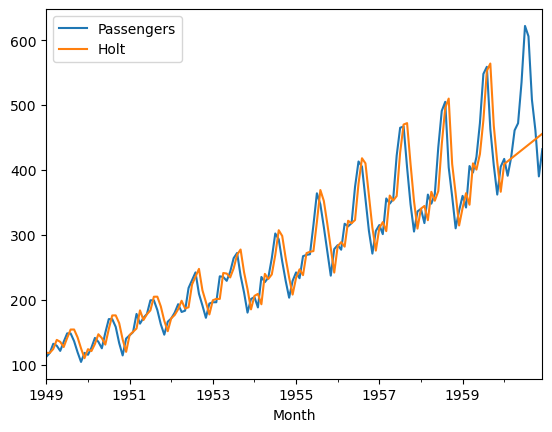

In [38]:
df[['Passengers', 'Holt']].plot();

## Holt-Winters Code Start

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [48]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

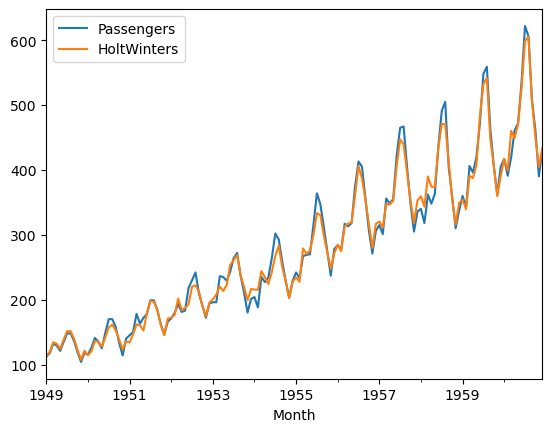

In [49]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [50]:
def rmse(y, t):
    return np.sqrt(np.mean((y - t)**2))

In [54]:
def mae(y, t):
    return np.mean(np.abs(y - t))

In [55]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  11.85299098495317
Test RMSE:  15.543040671839746


In [56]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  8.892027859335215
Test MAE:  10.437833883857872


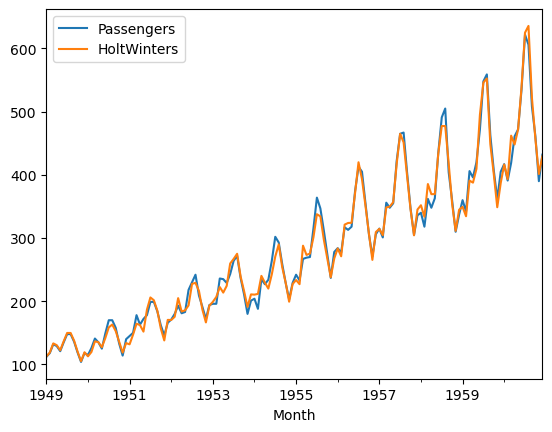

In [57]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [58]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  10.153934838980362
Test RMSE:  16.53521352526533


In [59]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  7.552052488307954
Test MAE:  10.68334189438329


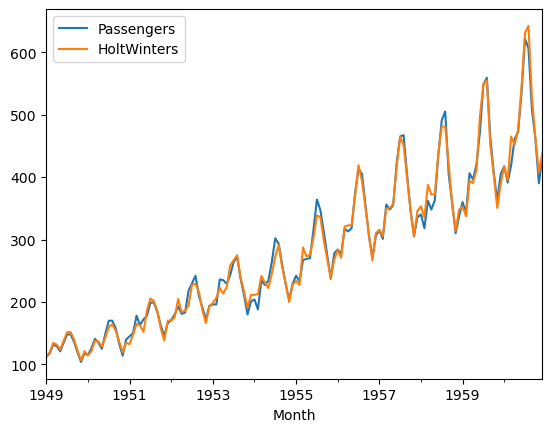

In [60]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [61]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  9.887178133885527
Test RMSE:  19.102102837542144


In [62]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  7.408706905731018
Test MAE:  13.450528282526767
